## Campos involucrados

- escuelascercanas
- centroscomercialescercanos
- idzona

## Ideas

- Agregar info externa (transporte cercano? barrios "de moda"?)
- Caracterización de zona
  - Centro Geográfico
  - ¿diámetro?
  - Promedios
    - metroscubiertos
    - precio
    - ...
- Armar un dataframe con info de zonas?


## Problema

- Dado un grupo de coordenadas geográficas, no es tan sencillo calcular áreas y distancias (habría que proyectar). 

__Hay publicaciones cuyas coordenadas son demasiado lejanas a las del resto de la zona__
¿Cómo las encuentro?
- Distancia al centro de la zona (¿promedio de latitud-longitud u otra medida?)


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point, Polygon
import numpy

In [2]:
# importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
# importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [3]:
# cargo el dataset
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'mes', 'ano', 'dia',
       'precio_metro_cubierto', 'precio_metro_total', 'gps'],
      dtype='object')

In [5]:
def agg_polygon(point_series):
    """
        Recibe un pd.Series de geometry.Point
        Devuelve un Polygon de los puntos de la serie, o NaN si
        no tiene suficientes puntos (3).
    """
    values = point_series.loc[~point_series.isna()].values
    if len(values) < 3: return numpy.NaN
    return Polygon([[p.x, p.y] for p in values])

## Armo un Dataframe donde las filas son las zonas

In [6]:
calculations = ["mean","std","max","min"]
aggregations = {"id": "count",\
                "precio_metro_total": calculations,\
                "precio_metro_cubierto": calculations,\
                "antiguedad": calculations,\
                "habitaciones": calculations,\
                "metroscubiertos": calculations,\
                "metrostotales": calculations,\
                "lat": calculations,\
                "lng": calculations,\
                "precio": calculations,\
                "habitaciones": calculations,\
                "garages": calculations,\
                "banos": calculations,\
                "gps": agg_polygon\
               }
zonas = df.groupby(["idzona"]).agg(aggregations)
zonas.columns = [x+"_"+y for x,y in zonas.columns]
zonas.rename({"gps_agg_polygon": "polygon"}, axis="columns", inplace=True)

In [18]:
zonas["lat_dif"] = zonas["lat_max"] - zonas["lat_min"]
zonas["lng_dif"] = zonas["lng_max"] - zonas["lng_min"]

In [62]:
zonas.shape

(19719, 48)

In [53]:
zonas[["lat_dif","lng_dif"]].describe()

,lat_dif,lng_dif
count,14967.000000,14967.000000
mean,0.594770,2.871664
std,3.734928,18.934023
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001700,0.001790
75%,0.021283,0.023301
max,102.820840,220.917327


In [64]:
zonas_ok = zonas.loc[(zonas["lat_dif"] < zonas["lat_dif"].mean()) & (zonas["lng_dif"] < zonas["lng_dif"].mean())]
zonas_ok.shape

(14255, 48)

In [7]:
pais = geopandas.read_file("./MEX_adm/MEX_adm0.shp")
estados = geopandas.read_file("./MEX_adm/MEX_adm1.shp")

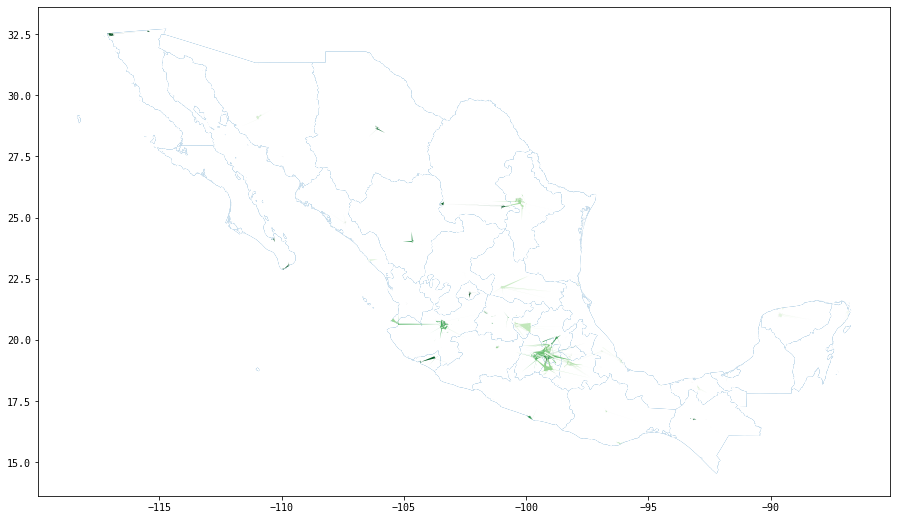

In [65]:
con_polygon = zonas_ok.loc[~zonas["polygon"].isna()]
geoDF = geopandas.GeoDataFrame(con_polygon, geometry="polygon")
base = pais.plot(figsize=(18,9))
estados_plot = estados.plot(ax=base, color="white")
plot = geoDF.plot(ax=estados_plot, cmap="Greens_r")

In [75]:
zonas_ok.loc[:,"centroid"] = zonas_ok.loc[~zonas_ok["polygon"].isna()]["polygon"].map(lambda x: x.centroid)

In [78]:
zonas_ok.sort_values(by="id_count", ascending=False)

,id_count,precio_metro_total_mean,precio_metro_total_std,precio_metro_total_max,precio_metro_total_min,precio_metro_cubierto_mean,precio_metro_cubierto_std,precio_metro_cubierto_max,precio_metro_cubierto_min,antiguedad_mean,...,garages_max,garages_min,banos_mean,banos_std,banos_max,banos_min,polygon,lat_dif,lng_dif,centroid
idzona,,,,,,,,,,,,,,,,,,,,,
84028.0,610.0,11009.720104,2582.311642,22413.793103,1903.278431,10880.046508,1975.915696,22413.793103,2929.687500,0.420654,...,3.0,0.0,2.423828,0.643555,4.0,1.0,"POLYGON ((-100.3527645060547 20.6460038109047,...",0.439569,0.648001,POINT (-99.98406126625852 20.54161490468353)
24823.0,575.0,19349.931317,8530.907233,60000.000000,2176.470588,17162.627796,9533.312801,200000.000000,2418.300654,7.921875,...,3.0,0.0,2.041016,0.800293,4.0,1.0,POLYGON ((-99.19589997523805 19.27962060115258...,0.371646,0.193023,POINT (-99.09073015406193 19.30740897549584)
339455.0,513.0,12921.119017,5081.532061,41089.108911,2876.543210,12027.004663,4231.243196,35047.619048,3030.303030,2.246094,...,3.0,0.0,2.412109,0.698242,4.0,1.0,"POLYGON ((-100.3482241 20.5986037, -100.343208...",0.115853,0.130680,POINT (-100.3932533256459 20.59900250636169)
343015.0,503.0,12290.126879,3941.583475,33333.333333,3500.000000,11698.947261,2778.120084,33333.333333,6209.935897,3.583984,...,3.0,0.0,2.375000,0.751465,4.0,1.0,"POLYGON ((-101.0400145 22.1500569, -101.028715...",0.516280,1.181095,POINT (-100.6992523319665 22.26613111263083)
47735.0,442.0,18846.159074,4613.109616,33108.108108,5510.460251,16350.122465,2760.791604,26870.748299,7242.990654,0.967773,...,3.0,0.0,3.214844,0.741699,4.0,1.0,POLYGON ((-103.4538077171875 20.71414000228824...,0.433882,1.816837,POINT (-97.34289328319723 22.06542613247069)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36441.0,1.0,7441.860465,NaN,7441.860465,7441.860465,5517.241379,NaN,5517.241379,5517.241379,7.000000,...,2.0,2.0,2.000000,NaN,2.0,2.0,NaN,0.000000,0.000000,NaN
91657.0,1.0,8737.864078,NaN,8737.864078,8737.864078,5471.124620,NaN,5471.124620,5471.124620,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
36379.0,1.0,NaN,NaN,NaN,NaN,22166.666667,NaN,22166.666667,22166.666667,20.000000,...,3.0,3.0,3.000000,NaN,3.0,3.0,NaN,0.000000,0.000000,NaN


In [81]:
publicaciones_84028 = df.loc[df["idzona"]==84028.0] 
publicaciones_84028.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total,gps
82,18684,oportunidad unica el refugio 3 rec con vestido...,hermosas y unicas residencias nuevas en el ref...,Casa en condominio,RESIDENCIAL DIAMANTE,Querétaro,Querétaro,0.0,3.0,2.0,...,True,True,True,1300000.0,8,2015,21,12037.037037,13265.306122,POINT (-100.3527645060547 20.6460038109047)


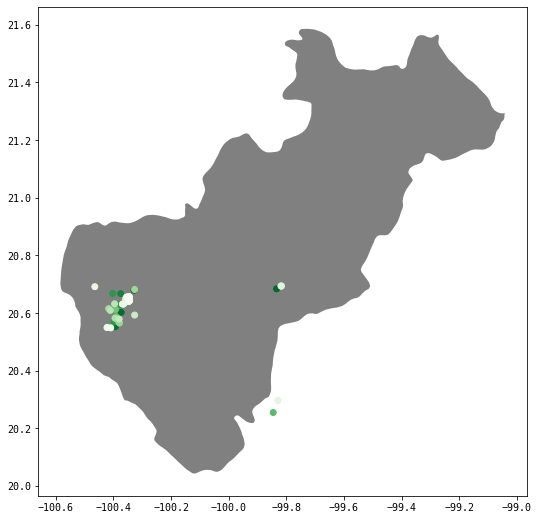

In [88]:
geoDF = geopandas.GeoDataFrame(publicaciones_84028, geometry="gps")
queretaro = estados.loc[estados["NAME_1"]=="Querétaro"].plot(figsize=(18,9),color="gray")
plot = geoDF.plot(ax=queretaro, cmap="Greens_r")